In [82]:
import cv2
import numpy as np
import torch.cuda
import matplotlib.pyplot as plt
from PIL import Image

from utils import plot_img, box_center2corner, intersection_over_union, iou_per_box, label2char
from detection.handcrafted import Preprocess, DetectChars, DetectPlates, Detect

import warnings
warnings.filterwarnings('ignore')


device = 'cuda' if torch.cuda.is_available() else 'cpu'

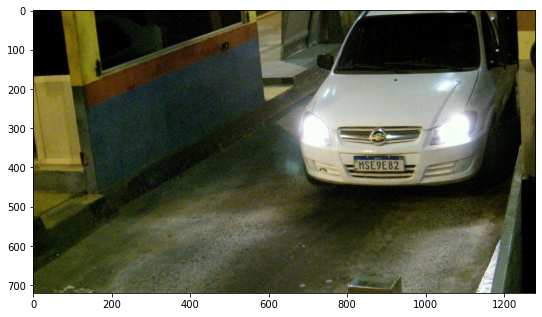

In [83]:
img = cv2.imread('testing_img/img.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plot_img(img)

predict plate: MSE9E82


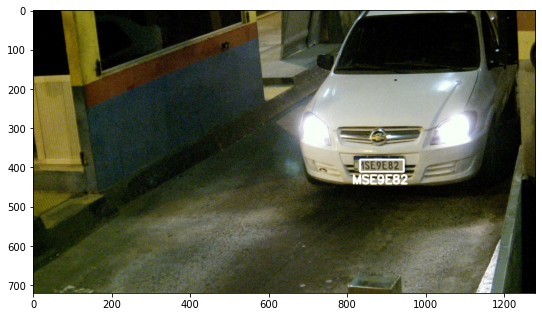

In [84]:
def end2end_character_based(img):  # RGB image
    from recognition.character_based import model_chacter_based, ctc_decoder
    ####################---DETECTION---##########################
    list_possible_plate1 = DetectPlates.detect_plates(img, 19, 9)
    list_possible_plate2 = DetectPlates.detect_plates(img, 39, 1)
    list_possible_plate = Detect.remove_overlapping_plate(list_possible_plate1, list_possible_plate2)
    plates = []
    boxes = []

    for plate in list_possible_plate:
        img_plate = plate.img_plate
        img_plate = cv2.resize(img_plate, (128, 32), interpolation=Image.BILINEAR)
        img_plate = np.array(img_plate)
        img_plate = cv2.cvtColor(img_plate, cv2.COLOR_RGB2GRAY)
        img_plate = (img_plate / 127.5) - 1.0
        img_plate = torch.FloatTensor(img_plate).unsqueeze(0)
        plates.append(img_plate)
        boxes.append(plate.box)

    ####################---RECOGNITION---##########################
    crnn = model_chacter_based.CRNN(1, 32, 128, 37).to(device)
    checkpoint_path = 'checkpoint/crnn.pt'
    checkpoint = torch.load(checkpoint_path, map_location=torch.device(device))
    crnn.load_state_dict(checkpoint)

    for i, plate_img in enumerate(plates):
        logits = crnn(plate_img.unsqueeze(0).to(device))
        log_probs = torch.nn.functional.log_softmax(logits, dim=2)
        preds = ctc_decoder.ctc_decode(log_probs, method='beam_search', beam_size=10)
        preds_str = label2char(preds)
        print("predict plate:", preds_str[0])

        x, y, h, w = boxes[i]
        x1, y1, x2, y2 = box_center2corner(boxes[i])
        x, y, w, h = int(x1), int(y1), int(w), int(h)


        font = cv2.FONT_HERSHEY_SIMPLEX
        fontScale = 1
        color = (255, 255, 255)
        thickness = 3
        cv2.rectangle(img, (int(x), int(y)), (int(x + w), int(y + h)), color, thickness)
        cv2.putText(img, preds_str[0], (x-20, y+ h + 30), font, fontScale, color, thickness, cv2.LINE_AA)

    plot_img(img)

img1 = img.copy()
end2end_character_based(img1)

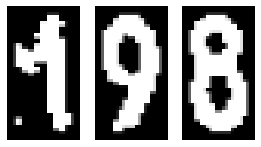

predict plate: A90


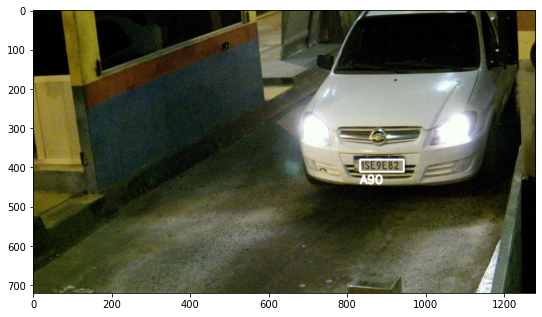

In [85]:
def end2end_segment_based(img): # RGB image
    from recognition.segment_based import segment_character, evaluate, model
    model1 = model.Segment_character(36).to(device)
    checkpoint_path = 'checkpoint/character_model.pt'
    checkpoint = torch.load(checkpoint_path, map_location=torch.device(device))
    model1.load_state_dict(checkpoint)
    ####################---DETECTION---##########################
    list_possible_plate1 = DetectPlates.detect_plates(img, 19, 9)
    list_possible_plate2 = DetectPlates.detect_plates(img, 39, 1)
    list_possible_plate = Detect.remove_overlapping_plate(list_possible_plate1, list_possible_plate2)

    plates = []
    boxes = []
    for plate in list_possible_plate:
        img_plate = plate.img_plate
        plates.append(img_plate)
        boxes.append(plate.box)

    ####################---RECOGNITION---##########################

    for i, plate_img in enumerate(plates):
        plate_img = np.array(plate_img, dtype='uint8')
        chars = segment_character.segment_characters(plate_img)
        for j in range(len(chars)):
            plt.subplot(1, len(chars) + 1, j + 1)
            plt.imshow(chars[j], cmap='gray')
            plt.axis('off')
        plt.show()

        pred_str = [evaluate.show_results(chars, model1)]
        print("predict plate:", pred_str[0])

        x, y, h, w = boxes[i]
        x1, y1, x2, y2 = box_center2corner(boxes[i])
        x, y, w, h = int(x1), int(y1), int(w), int(h)


        font = cv2.FONT_HERSHEY_SIMPLEX
        fontScale = 1
        color = (255, 255, 255)
        thickness = 3
        cv2.rectangle(img, (int(x), int(y)), (int(x + w), int(y + h)), color, thickness)
        cv2.putText(img, pred_str[0], (x, y+ h + 30), font, fontScale, color, thickness, cv2.LINE_AA)


    plot_img(img)

img2 = img.copy()
end2end_segment_based(img2)